In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

train_x = train_x.cuda()
train_y = train_y.cuda()

In [10]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
        devices = [0, 1]
        
        self.covar_module = gpytorch.kernels.MultiDeviceKernel(base_covar_module, device_ids=devices, output_device=torch.device('cuda', 0))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood().to("cuda:0")
model = ExactGPModel(train_x, train_y, likelihood).to("cuda:0")


In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

with gpytorch.settings.max_preconditioner_size(5):
    training_iter = 50
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.module.base_kernel.log_lengthscale.item(),
            model.likelihood.log_noise.item()
        ))
        optimizer.step()

/home/jrg365/gpytorch/gpytorch/utils/pivoted_cholesky.py:103: UserWarning: torch.potrs is deprecated in favour of torch.cholesky_solve and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky_solve defaults to ``False``.
  R = torch.potrs(low_rank_mat, torch.cholesky(shifted_mat, upper=True))


Iter 1/50 - Loss: 0.937   log_lengthscale: -0.367   log_noise: -0.367
Iter 2/50 - Loss: 0.906   log_lengthscale: -0.439   log_noise: -0.439
Iter 3/50 - Loss: 0.873   log_lengthscale: -0.513   log_noise: -0.514
Iter 4/50 - Loss: 0.836   log_lengthscale: -0.589   log_noise: -0.590
Iter 5/50 - Loss: 0.794   log_lengthscale: -0.666   log_noise: -0.668
Iter 6/50 - Loss: 0.748   log_lengthscale: -0.744   log_noise: -0.747
Iter 7/50 - Loss: 0.699   log_lengthscale: -0.823   log_noise: -0.828
Iter 8/50 - Loss: 0.649   log_lengthscale: -0.905   log_noise: -0.911
Iter 9/50 - Loss: 0.601   log_lengthscale: -0.989   log_noise: -0.996
Iter 10/50 - Loss: 0.557   log_lengthscale: -1.072   log_noise: -1.082
Iter 11/50 - Loss: 0.518   log_lengthscale: -1.153   log_noise: -1.169
Iter 12/50 - Loss: 0.483   log_lengthscale: -1.230   log_noise: -1.258
Iter 13/50 - Loss: 0.447   log_lengthscale: -1.300   log_noise: -1.349
Iter 14/50 - Loss: 0.413   log_lengthscale: -1.360   log_noise: -1.440
Iter 15/50 - Lo

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = model(test_x)
    observed_pred = likelihood(observed_pred)

/home/jrg365/gpytorch/gpytorch/utils/pivoted_cholesky.py:103: UserWarning: torch.potrs is deprecated in favour of torch.cholesky_solve and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky_solve defaults to ``False``.
  R = torch.potrs(low_rank_mat, torch.cholesky(shifted_mat, upper=True))


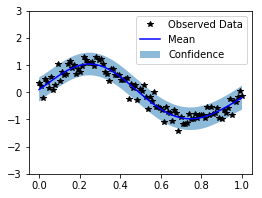

In [6]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.squeeze().cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.savefig('res.pdf')